# "A breath of fresh air" - ML project documentation

**Table of contents**<a id='toc0_'></a>    
- [Preparations](#toc1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Preparations and Data Exploitation](#toc0_)

To start with the project, as a first step the necessary libraries are imported. Afterwards the files needed are loaded.

In [27]:
# import libraries and tools
import pandas as pd
import numpy as np
import missingno as msno
import metpy.calc
from metpy.units import units

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split

from variable_names import to_keep
from functions import test_train_time_split

import warnings
warnings.filterwarnings('ignore')

In [28]:
# get data
df = pd.read_csv('data/Train.csv')

Next, one might want to get an overview what the data looks like, how large the DataFrame is and what it contains.

In [29]:
df.head()

,Place_ID X Date,Date,Place_ID,target,target_min,target_max,target_variance,target_count,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,...,L3_SO2_sensor_zenith_angle,L3_SO2_solar_azimuth_angle,L3_SO2_solar_zenith_angle,L3_CH4_CH4_column_volume_mixing_ratio_dry_air,L3_CH4_aerosol_height,L3_CH4_aerosol_optical_depth,L3_CH4_sensor_azimuth_angle,L3_CH4_sensor_zenith_angle,L3_CH4_solar_azimuth_angle,L3_CH4_solar_zenith_angle
0,010Q650 X 2020-01-02,2020-01-02,010Q650,38.0,23.0,53.0,769.50,92,11.000000,60.200001,...,38.593017,-61.752587,22.363665,1793.793579,3227.855469,0.010579,74.481049,37.501499,-62.142639,22.545118
1,010Q650 X 2020-01-03,2020-01-03,010Q650,39.0,25.0,63.0,1319.85,91,14.600000,48.799999,...,59.624912,-67.693509,28.614804,1789.960449,3384.226562,0.015104,75.630043,55.657486,-53.868134,19.293652
2,010Q650 X 2020-01-04,2020-01-04,010Q650,24.0,8.0,56.0,1181.96,96,16.400000,33.400002,...,49.839714,-78.342701,34.296977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,010Q650 X 2020-01-05,2020-01-05,010Q650,49.0,10.0,55.0,1113.67,96,6.911948,21.300001,...,29.181258,-73.896588,30.545446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010Q650 X 2020-01-06,2020-01-06,010Q650,21.0,9.0,52.0,1164.82,95,13.900001,44.700001,...,0.797294,-68.612480,26.899694,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset includes 82 variables and over 30,000 entries. Within the time frame January to April 2020 data of more than 300 individual locations is given about meteorological parameters, air chemistry and clouds, derived from in-situ measurements as well as satellite pictures.
**Target value** of the projects modelling is the PM2.5 concentration on a single day at a single location.

For this project, not all columns will be used. The ones that are not of relevance for the data evaluation and modelling are included in the file "variable_names". They are removed from the DataFrame. 

We decided on the possible impact of the variables on the PM2.5 concentration by common sense (e.g. sensor height and solar azimuth are removed).

The remaining features are then visualised on a correlation heatmap. Where two features had high correlation with each other, the feature with lower correlation to PM2.5 is removed.

In [30]:
df = df[to_keep]

<AxesSubplot:>

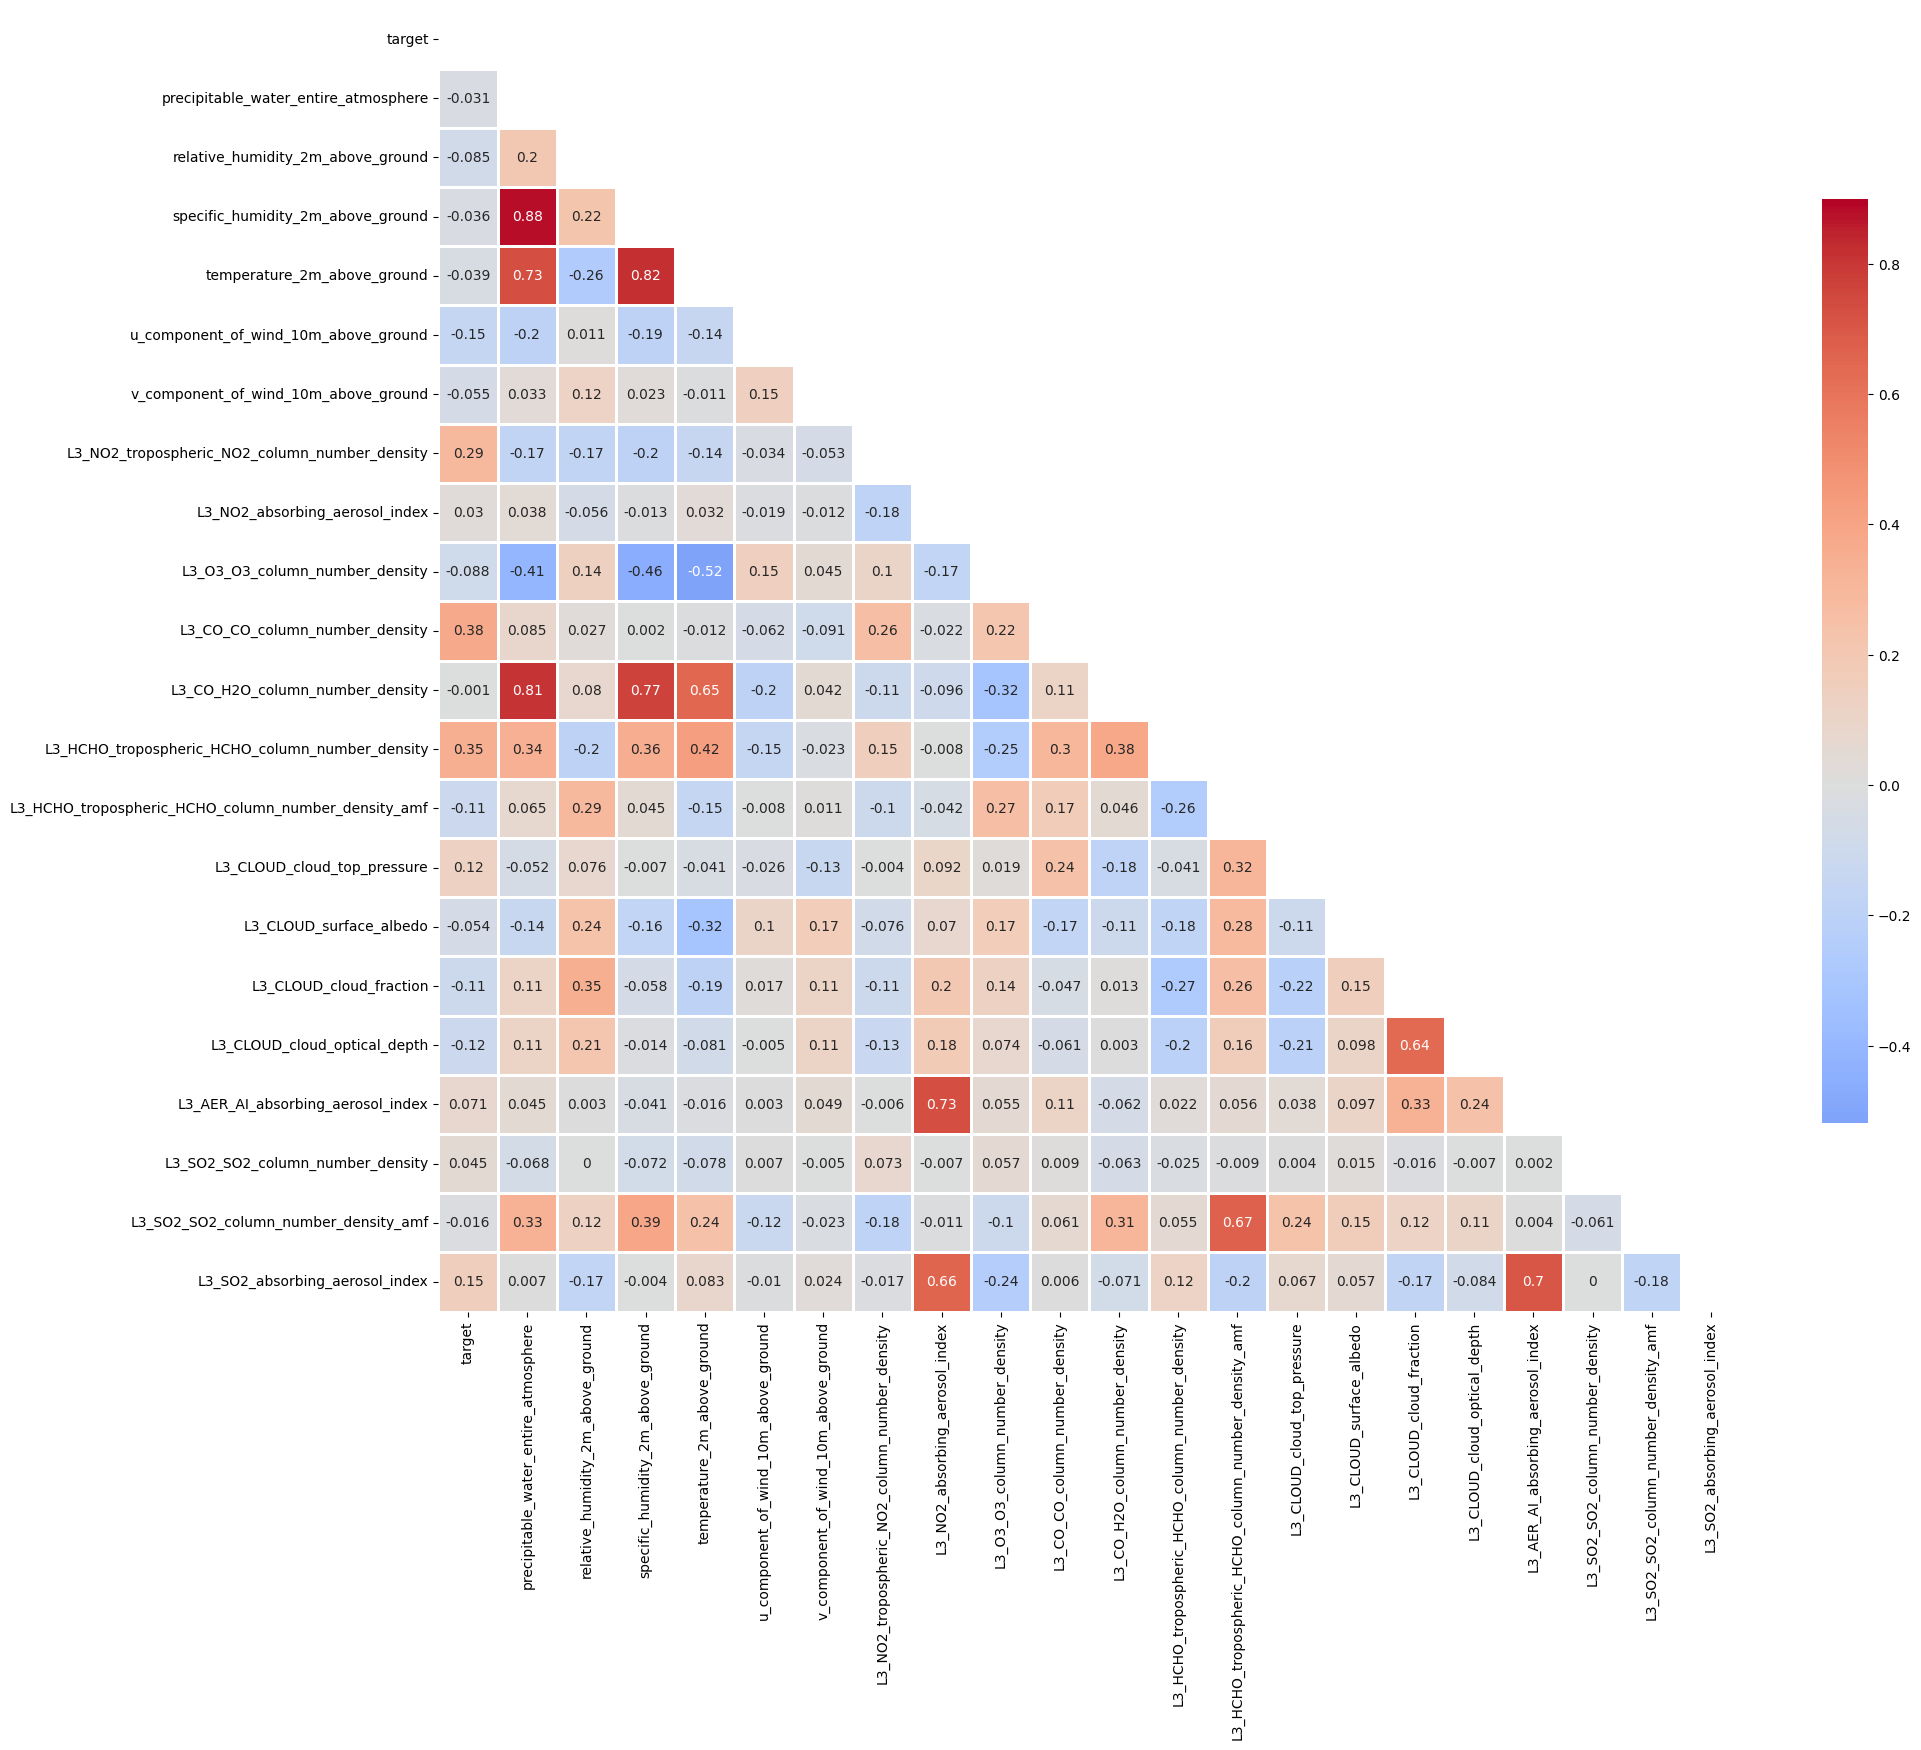

In [31]:
#Create correlation matrix

corr = df.corr().round(3)

#Plot Correlation matrix

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(21, 20))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.9, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": .6}, annot=True)

Exploring the data is good practice to get used to it.

In [32]:
# information on column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30557 entries, 0 to 30556
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Date                                                 30557 non-null  object 
 1   Place_ID                                             30557 non-null  object 
 2   target                                               30557 non-null  float64
 3   precipitable_water_entire_atmosphere                 30557 non-null  float64
 4   relative_humidity_2m_above_ground                    30557 non-null  float64
 5   specific_humidity_2m_above_ground                    30557 non-null  float64
 6   temperature_2m_above_ground                          30557 non-null  float64
 7   u_component_of_wind_10m_above_ground                 30557 non-null  float64
 8   v_component_of_wind_10m_above_ground                 30557 non-nul

<AxesSubplot:>

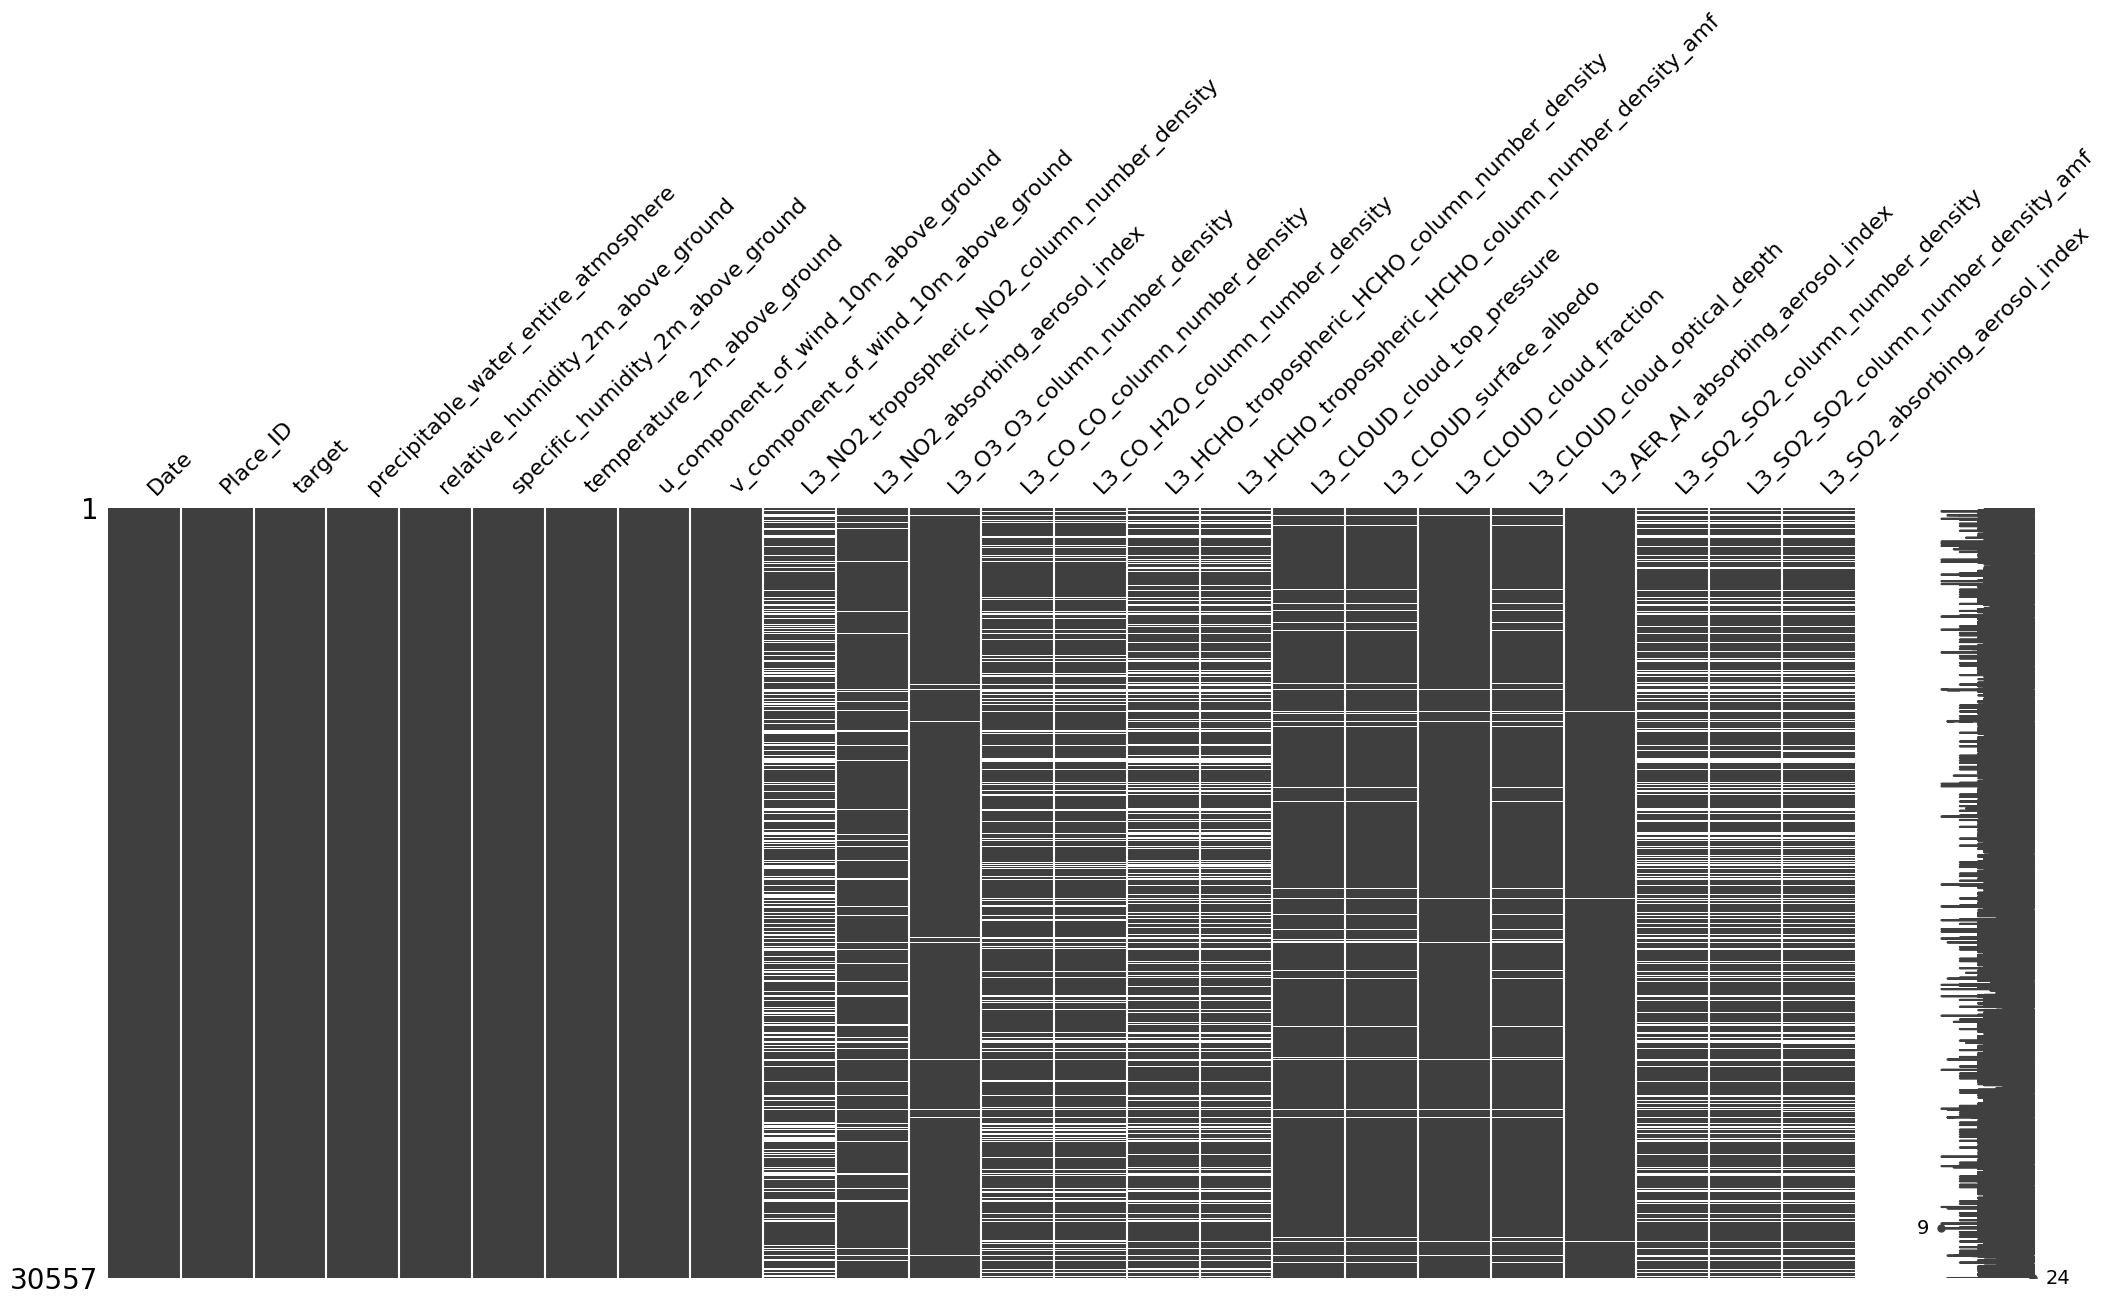

In [33]:
# display missing values visualized
msno.matrix(df)

As the description of the data from the source (zindi.com) already stated, especially the satellite data on CH4 shows some gaps. Other data is also missing for several locations and dates.

# Data cleaning and feature engineering

To make some of the measurement data given more handy we will derive new variables from them, so-called "feature engineering".

In [34]:
# calculate wind direction from components u and v
uwind = np.array(df['u_component_of_wind_10m_above_ground']) * units('m/s')
vwind = np.array(df['v_component_of_wind_10m_above_ground']) * units('m/s')

df['winddir'] = metpy.calc.wind_direction(uwind, vwind)
df['windspeed'] = metpy.calc.wind_speed(uwind, vwind)

df = df.drop('u_component_of_wind_10m_above_ground', axis=1)
df = df.drop('v_component_of_wind_10m_above_ground', axis=1)

In [35]:
# how many days of data for each location is given
df['placeID_freq'] = df['Place_ID'].map(df['Place_ID'].value_counts())

# number of unique locations
df.Place_ID.nunique()

340

In [36]:
# convert to pd datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# create a column with the  weekday
df['weekday'] = df.Date.dt.dayofweek # Monday = 0

To get a consistent dataset, several steps need to be conducted for cleaning.

In [37]:
# Are there any duplicates in the data
df.duplicated().value_counts()

False    30557
dtype: int64

Plot histograms of remaining features of remaining to understand if any features require transformation.

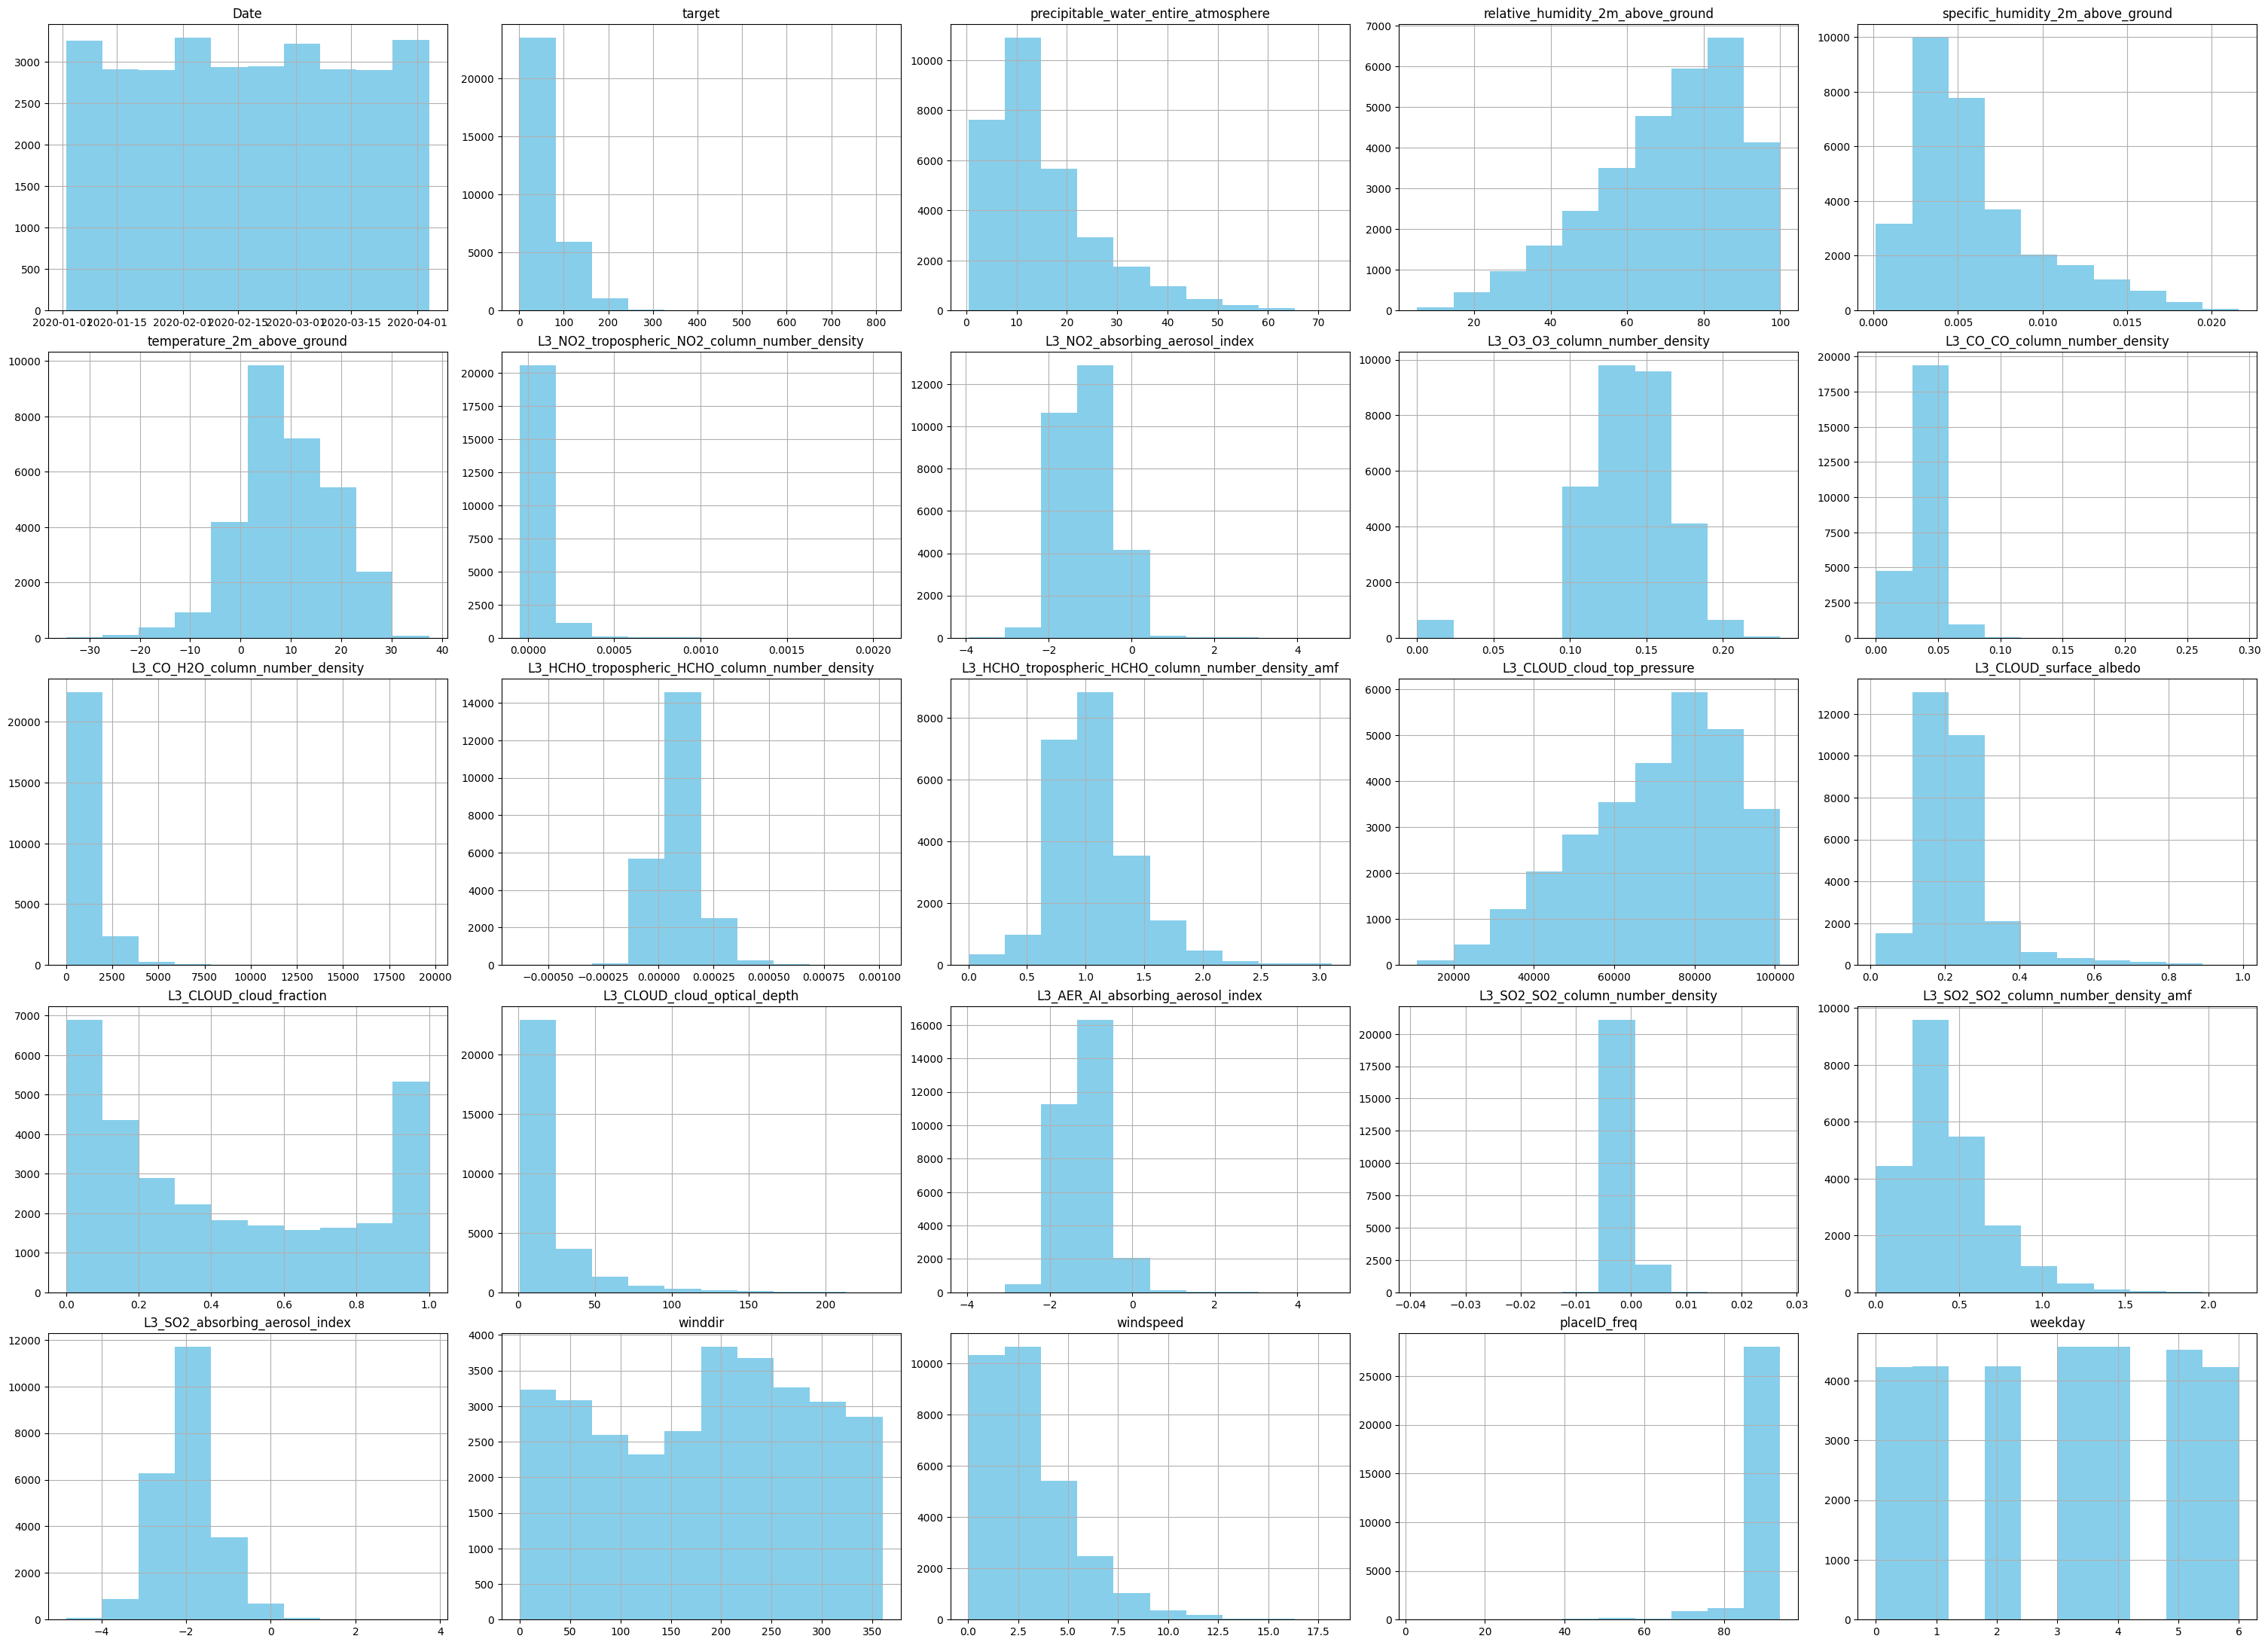

In [38]:
fig = plt.figure(constrained_layout = True) 
fig.set_figheight(80)
fig.set_figwidth(30)
plt.suptitle('Distribution of features', fontsize=20)

ax = fig.gca()
df.hist(ax=ax, color = "skyblue",layout=(20,5))
plt.show()